In [2]:
# Импорт стандартных библиотек
import pandas as pd
import numpy as np
import random

import os

# Для разделения данных и предобработки
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Для построения модели LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Для генетического алгоритма
from deap import base, creator, tools, algorithms

# Для оценки модели
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Для визуализации
import matplotlib.pyplot as plt
%matplotlib inline

# Дополнительные библиотеки
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

import joblib

# Этап 1: Подготовка данных

#### Загрузка данных

In [155]:
data = pd.read_csv('data/sp500_historical_data.csv')

#### Преобразование столбца даты

In [158]:
data['Date'] = pd.to_datetime(data['Date'])

#### Удаление данных за выходные дни

In [161]:
data = data[data['Date'].dt.weekday < 5]

#### Определение полного диапазона дат

In [164]:
full_date_range = pd.date_range(start=data['Date'].min(), end=data['Date'].max(), freq='B')  # 'B' обозначает бизнес-день

#### Проверка наличия данных по каждому тикеру

In [167]:
data_pivot = data.pivot_table(index='Date', columns='Ticker', values='Adj Close')
missing_percent = data_pivot.isnull().mean() * 100
tickers_to_remove = missing_percent[missing_percent > 5].index.tolist()
clean_data = data[~data['Ticker'].isin(tickers_to_remove)]

#### Проверка на дупликаты

In [170]:
clean_data = clean_data.drop_duplicates()

#### Обработка подозрительно низкого объема торгов

In [173]:
volume_threshold = clean_data['Volume'].quantile(0.01)
low_volume_data = clean_data[clean_data['Volume'] <= volume_threshold]
low_volume_data.to_csv('data/low_volume_records.csv', index=False)

#### Проверка размерности данных

In [176]:
data_pivot_clean = clean_data.pivot_table(index='Date', columns='Ticker', values='Adj Close')
missing_dates_per_ticker = data_pivot_clean.isnull().sum()
tickers_with_missing_dates = missing_dates_per_ticker[missing_dates_per_ticker > 0].index.tolist()
clean_data = clean_data[~clean_data['Ticker'].isin(tickers_with_missing_dates)]

#### Сохранение очищенных данных

In [179]:
clean_tickers = clean_data['Ticker'].unique()
cleaned_data = data.sort_values(['Ticker', 'Date']).reset_index(drop=True)
clean_data.to_csv('data/cleaned_sp500_data.csv', index=False)

#### Разделение данных на обучающую и тестовую выборки

In [182]:
# Получение минимальной и максимальной даты
min_date = data['Date'].min()
max_date = data['Date'].max()

# Общий период времени
total_days = (max_date - min_date).days

# Дата разделения (80% от общего периода)
split_date = min_date + pd.Timedelta(days=int(total_days * 0.8))

print(f"Дата разделения данных: {split_date.date()}")
# Обучающая выборка: данные до даты разделения (включительно)
train_data = data[data['Date'] <= split_date]

# Тестовая выборка: данные после даты разделения
test_data = data[data['Date'] > split_date]
print(f"Размер обучающей выборки: {len(train_data)} записей")
print(f"Размер тестовой выборки: {len(test_data)} записей")


# Сохранение обучающей выборки
train_data.to_csv('data/sp500_train_data.csv', index=False)

# Сохранение тестовой выборки
test_data.to_csv('data/sp500_test_data.csv', index=False)

Дата разделения данных: 2022-05-25
Размер обучающей выборки: 298427 записей
Размер тестовой выборки: 74756 записей


#### Сбор информации о секторах

In [195]:
# Получение списка уникальных тикеров
tickers = data['Ticker'].unique()

# Инициализация словаря для хранения информации о секторах
ticker_sectors = {}

# Получение информации о секторах для каждого тикера
for ticker in tickers:
    try:
        stock_info = yf.Ticker(ticker).info
        sector = stock_info.get('sector', 'Unknown')
        ticker_sectors[ticker] = sector
    except Exception as e:
        print(f"Не удалось получить данные для {ticker}: {e}")
        ticker_sectors[ticker] = 'Unknown'

# Создание DataFrame из словаря
sectors_df = pd.DataFrame.from_dict(ticker_sectors, orient='index', columns=['Sector'])

sectors_df.to_csv('data/sectors.csv')

#### Сохранение волатильности

In [198]:
for ticker in tickers:
    # Получение данных для тикера
    df_ticker = data[data['Ticker'] == ticker].sort_values('Date')

    # Используем 'Adj Close' в качестве целевой переменной
    close_prices = df_ticker['Adj Close'].values.reshape(-1, 1)
    
    # Расчет доходностей для оценки волатильности
    returns = np.log(close_prices[1:] / close_prices[:-1])

    # Оценка волатильности (стандартное отклонение доходностей)
    volatility_value = np.std(returns)
    volatility[ticker] = volatility_value
    
# Преобразование словаря волатильности в DataFrame
volatility_df = pd.DataFrame.from_dict(volatility, orient='index', columns=['Volatility'])
volatility_df.to_csv('data/volatility.csv')

# Этап 2: Построение и оптимизация модели LSTM с помощью GA

#### Загрузка очищенных данных

In [227]:
# Загрузка обучающих данных
train_data = pd.read_csv('data/sp500_train_data.csv')

# Преобразование столбца 'Date' в формат datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Сортировка данных
train_data = train_data.sort_values(['Ticker', 'Date']).reset_index(drop=True)

#### Подготовка данных

In [230]:
# Определение параметров
TIME_STEPS = 30  # Длина последовательности для входа в LSTM

# Инициализация словарей для хранения результатов
models = {}
scalers = {}
volatility = {}
performance = {}

#### Установка random для воспроизведения

In [233]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#### Определение функций для подготовки данных

In [236]:
def create_sequences(data, time_steps=TIME_STEPS):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

#### Определение функции оценки модели

In [239]:
import tensorflow.keras.backend as K

def evaluate_model(individual, X_train, y_train, X_val, y_val):
    # Unpack hyperparameters
    n_layers = individual[0]
    n_neurons = individual[1]
    dropout_rate = individual[2]
    learning_rate = individual[3]

    # Build the model
    K.clear_session()
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    if n_layers == 1:
        # Single LSTM layer
        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout_rate))
    else:
        # First LSTM layer
        model.add(LSTM(units=n_neurons, return_sequences=True))
        model.add(Dropout(dropout_rate))
        # Middle LSTM layers
        for _ in range(n_layers - 2):
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout_rate))
        # Last LSTM layer
        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Train the model
    history = model.fit(X_train, y_train, epochs=5, batch_size=32,
                        validation_data=(X_val, y_val), verbose=0)

    # Evaluate validation loss
    val_loss = history.history['val_loss'][-1]

    return val_loss,

#### Определение процесса генетического алгоритма

In [242]:
def custom_mutation(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            if i == 0:  # n_layers (целое число)
                individual[i] = random.randint(1, 2)  # Максимум 2 слоя
            elif i == 1:  # n_neurons (целое число)
                individual[i] = random.randint(32, 128)  # От 32 до 128 нейронов
            elif i == 2:  # dropout_rate (вещественное число)
                individual[i] = random.uniform(0.0, 0.3)  # От 0.0 до 0.3
            elif i == 3:  # learning_rate (вещественное число)
                individual[i] = random.uniform(0.0005, 0.005)  # Уменьшенный диапазон
    return individual,

In [244]:
def optimize_model_with_ga(X_train, y_train, X_val, y_val, n_generations=3, population_size=5):
    # Определение индивидуала и функции приспособленности
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Минимизируем валидационную ошибку
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # Определение атрибутов для каждого гиперпараметра
    toolbox.register("attr_n_layers", random.randint, 1, 2)
    toolbox.register("attr_n_neurons", random.randint, 32, 128)
    toolbox.register("attr_dropout_rate", random.uniform, 0.0, 0.3)
    toolbox.register("attr_learning_rate", random.uniform, 0.0005, 0.005)

    # Создание индивидуала
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_n_layers, toolbox.attr_n_neurons, toolbox.attr_dropout_rate, toolbox.attr_learning_rate), n=1)

    # Создание популяции
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Определение функции оценки
    def eval_function(individual):
        return evaluate_model(individual, X_train, y_train, X_val, y_val)

    toolbox.register("evaluate", eval_function)
    toolbox.register("mate", tools.cxUniform, indpb=0.5)
    toolbox.register("mutate", custom_mutation, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Инициализация популяции
    pop = toolbox.population(n=population_size)

    # Использование Hall of Fame для отслеживания лучшего решения
    hof = tools.HallOfFame(1)

    # Параллельная оценка популяции
    def eval_population(population):
        fitnesses = Parallel(n_jobs=-1)(delayed(toolbox.evaluate)(ind) for ind in population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

    # Основной цикл GA
    for gen in range(n_generations):
        print(f"Поколение {gen+1}/{n_generations}")

        # Оценка популяции
        invalid_ind = [ind for ind in pop if not ind.fitness.valid]
        if invalid_ind:
            eval_population(invalid_ind)

        # Обновление Hall of Fame
        hof.update(pop)

        # Применение операторов GA
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.5, mutpb=0.2)

        # Оценка потомков
        invalid_offspring = [ind for ind in offspring if not ind.fitness.valid]
        if invalid_offspring:
            eval_population(invalid_offspring)
        
        # Вывод лучшей валидационной ошибки в текущем поколении
        best = tools.selBest(pop, k=1)[0]
        print(f"Лучшая валидационная ошибка: {best.fitness.values[0]}")

        # Выбор новой популяции
        pop = toolbox.select(pop + offspring, k=len(pop))

    # Возвращаем лучший найденный индивидуал
    best_individual = hof[0]
    return best_individual

#### Обучение модели для каждого тикера

In [ ]:
# Создание каталогов для сохранения моделей и графиков
if not os.path.exists('models'):
    os.makedirs('models')
if not os.path.exists('plots'):
    os.makedirs('plots')
if not os.path.exists('scalers'):
    os.makedirs('scalers')

tickers = train_data['Ticker'].unique()

# Цикл по каждому тикеру
for ticker in tickers:
    if not os.path.isfile(f'models/{ticker}_model.keras'):
        print(f"Обработка тикера: {ticker}")

        # Получение данных для тикера
        df_ticker = train_data[train_data['Ticker'] == ticker].sort_values('Date')

        # Используем 'Adj Close' в качестве целевой переменной
        close_prices = df_ticker['Adj Close'].values.reshape(-1, 1)

        # Проверка достаточности данных
        if len(close_prices) <= TIME_STEPS:
            print(f"Недостаточно данных для тикера {ticker}")
            continue

        # Масштабирование данных
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(close_prices)
        scalers[ticker] = scaler
        
        # Сохранение скейлера
        scaler_filename = f'scalers/{ticker}_scaler.save'
        joblib.dump(scaler, scaler_filename)

        # Создание последовательностей
        X, y = create_sequences(scaled_data)

        # Проверка достаточности последовательностей
        if len(X) == 0:
            print(f"Недостаточно последовательностей для тикера {ticker}")
            continue

        # Разделение данных на обучающую и тестовую выборки (80% на обучение)
        split_index = int(0.8 * len(X))
        X_train_full, X_test = X[:split_index], X[split_index:]
        y_train_full, y_test = y[:split_index], y[split_index:]

        # Дополнительное разделение обучающих данных на обучение и валидацию (80% на обучение)
        val_split_index = int(0.8 * len(X_train_full))
        X_train, X_val = X_train_full[:val_split_index], X_train_full[val_split_index:]
        y_train, y_val = y_train_full[:val_split_index], y_train_full[val_split_index:]

        # Оптимизация модели с помощью GA
        best_hyperparams = optimize_model_with_ga(X_train, y_train, X_val, y_val, n_generations=3, population_size=5)

        # Извлечение лучших гиперпараметров
        n_layers = best_hyperparams[0]
        n_neurons = best_hyperparams[1]
        dropout_rate = best_hyperparams[2]
        learning_rate = best_hyperparams[3]

        # Построение финальной модели с лучшими гиперпараметрами
        K.clear_session()
        model = Sequential()
        model.add(Input(shape=(X_train_full.shape[1], X_train_full.shape[2])))

        if n_layers == 1:
            # Single LSTM layer
            model.add(LSTM(units=n_neurons, return_sequences=False))
            model.add(Dropout(dropout_rate))
        else:
            # First LSTM layer
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout_rate))
            # Middle LSTM layers
            for _ in range(n_layers - 2):
                model.add(LSTM(units=n_neurons, return_sequences=True))
                model.add(Dropout(dropout_rate))
            # Last LSTM layer
            model.add(LSTM(units=n_neurons, return_sequences=False))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1))

        # Compile the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)

        # Обучение финальной модели на полной обучающей выборке
        model.fit(X_train_full, y_train_full, epochs=20, batch_size=32, verbose=0)

        # Оценка модели на тестовых данных
        y_pred = model.predict(X_test)
        y_pred_inverse = scaler.inverse_transform(y_pred)
        y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Расчет метрик оценки
        mse = mean_squared_error(y_test_inverse, y_pred_inverse)
        mae = mean_absolute_error(y_test_inverse, y_pred_inverse)

        performance[ticker] = {'MSE': mse, 'MAE': mae}

        # Сохранение модели
        model.save(f'models/{ticker}_model.keras')
        models[ticker] = model

        # Визуализация результатов
        plt.figure(figsize=(10, 6))
        plt.plot(y_test_inverse, label='Реальная цена')
        plt.plot(y_pred_inverse, label='Предсказанная цена')
        plt.title(f'Предсказание цены для {ticker}')
        plt.xlabel('Время')
        plt.ylabel('Цена')
        plt.legend()
        plt.savefig(f'plots/{ticker}_prediction.png')
        plt.close()
    else:
        print(f"Модель для тикера: {ticker} уже создана")

#### Сохранение метрик модели

In [254]:
# Преобразование словаря производительности в DataFrame
performance_df = pd.DataFrame.from_dict(performance, orient='index')
performance_df.to_csv('data/model_performance.csv')

# Этап 3: Формирование портфеля

In [6]:
# Загрузка списка тикеров из файлов моделей
model_files = os.listdir('models')
clean_tickers = [filename.split('_model.keras')[0] for filename in model_files if filename.endswith('_model.keras')]

In [8]:
models = {}
scalers = {}

for ticker in clean_tickers:
    model_path = f'models/{ticker}_model.keras'
    scaler_path = f'scalers/{ticker}_scaler.save'
    if os.path.exists(model_path) and os.path.exists(scaler_path):
        models[ticker] = load_model(model_path)
        scalers[ticker] = joblib.load(scaler_path)
    else:
        print(f"Модель или скейлер для тикера {ticker} не найдены.")

In [9]:
# Загрузка тестовых данных
test_data = pd.read_csv('data/sp500_test_data.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data = test_data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

In [10]:
# Загрузка данных по индексу S&P 500
sp500_data = pd.read_csv('data/sp500_index_data.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data = sp500_data.sort_values('Date').reset_index(drop=True)

In [11]:
# Получение уникальных торговых дат в тестовом наборе данных
test_dates = sorted(test_data['Date'].unique())

# Выбор каждой 5-й даты для пересмотра портфеля
review_dates = test_dates[::5]

In [12]:
portfolio_history = []
portfolio_returns = []
index_returns = []
dates = []

In [ ]:
TIME_STEPS = 30  # Длина последовательности для LSTM

# Создание директории для сохранения предсказаний
if not os.path.exists('predictions'):
    os.makedirs('predictions')

for i in range(len(review_dates) - 1):
    current_date = review_dates[i]
    print(f"\nПредсказание цен на дату: {current_date.date()}")
    
    # Проверяем, сохранены ли предсказания для текущей даты
    prediction_file = f'predictions/predictions_{current_date.date()}.csv'
    if os.path.exists(prediction_file):
        print(f"Предсказания для {current_date.date()} уже сохранены.")
        continue
    
    # Словарь для хранения предсказаний
    predictions_dict = {'Ticker': [], 'Predicted Price': []}
    
    for ticker in clean_tickers:
        if ticker not in models or ticker not in scalers:
            continue

        # Получаем данные для тикера до текущей даты
        df_ticker = test_data[(test_data['Ticker'] == ticker) & (test_data['Date'] <= current_date)].sort_values('Date')

        # Проверяем, есть ли достаточное количество данных
        if len(df_ticker) < TIME_STEPS + 7:
            continue

        # Получаем последние TIME_STEPS данных для предсказания
        last_data = df_ticker.iloc[-TIME_STEPS:]
        last_close_prices = last_data['Adj Close'].values.reshape(-1, 1)

        # Масштабируем данные
        scaler = scalers[ticker]
        scaled_data = scaler.transform(last_close_prices)

        # Формируем входные данные для модели
        X_input = np.array([scaled_data])

        # Делаем предсказание на 7 дней вперед
        # Рекурсивное предсказание
        predictions = []
        current_input = X_input.copy()
        for _ in range(7):
            predicted_price = models[ticker].predict(current_input)
            predictions.append(predicted_price[0, 0])

            # Преобразуем predicted_price в правильную форму
            predicted_price_reshaped = predicted_price.reshape((1, 1, 1))

            # Обновляем current_input
            current_input = np.concatenate((current_input[:, 1:, :], predicted_price_reshaped), axis=1)

        # Обратное масштабирование предсказанных цен
        predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

        # Текущая цена
        current_price = last_close_prices[-1, 0]

        # Предсказанная цена через 7 дней
        predicted_price_7d = predicted_prices[-1, 0]

        # Сохраняем предсказанную цену
        predictions_dict['Ticker'].append(ticker)
        predictions_dict['Predicted Price'].append(predicted_price_7d)

#         # Построение графика сравнения
#         # Получаем реальные цены за следующий период
#         df_future = test_data[(test_data['Ticker'] == ticker) & (test_data['Date'] > current_date)].sort_values('Date').head(7)
#         real_prices = df_future['Adj Close'].values

#         plt.figure(figsize=(10, 5))
#         plt.plot(range(len(real_prices)), real_prices, label='Реальные цены')
#         plt.plot(range(len(predicted_prices)), predicted_prices, label='Предсказанные цены')
#         plt.title(f"{ticker} - Предсказание цен с {current_date.date()}")
#         plt.xlabel('Дни вперед')
#         plt.ylabel('Цена')
#         plt.legend()
#         plt.show()

    # Сохранение предсказаний в CSV
    predictions_df = pd.DataFrame(predictions_dict)
    predictions_df.to_csv(prediction_file, index=False)
    print(f"Предсказания сохранены в {prediction_file}")

In [19]:
portfolio_history = []
portfolio_returns = []
index_returns = []
dates = []

for i in range(len(review_dates) - 1):
    current_date = review_dates[i]
    next_date = review_dates[i + 1]
    print(f"\nПересмотр портфеля на дату: {current_date.date()}")

    # Загрузка предсказанных цен
    prediction_file = f'predictions/predictions_{current_date.date()}.csv'
    if not os.path.exists(prediction_file):
        print(f"Предсказания для {current_date.date()} не найдены. Пропуск даты.")
        continue

    predictions_df = pd.read_csv(prediction_file)
    predictions_df.set_index('Ticker', inplace=True)

    # Словарь для хранения ожидаемой доходности и волатильности
    expected_returns = {}

    for ticker in predictions_df.index:
        if ticker not in scalers:
            continue

        # Получаем данные для тикера до текущей даты
        df_ticker = test_data[(test_data['Ticker'] == ticker) & (test_data['Date'] <= current_date)].sort_values('Date')

        # Проверяем, есть ли достаточное количество данных
        if len(df_ticker) < TIME_STEPS:
            continue

        # Текущая цена
        current_price = df_ticker.iloc[-1]['Adj Close']

        # Предсказанная цена через 7 дней
        predicted_price_7d = predictions_df.loc[ticker]['Predicted Price']

        # Рассчитываем ожидаемую доходность
        expected_return = (predicted_price_7d - current_price) / current_price

        # Волатильность рассчитываем на основе исторических данных
        df_ticker['Return'] = df_ticker['Adj Close'].pct_change()
        volatility = df_ticker['Return'].std()

        # Сохраняем ожидаемую доходность и волатильность
        expected_returns[ticker] = {
            'Expected Return': expected_return,
            'Volatility': volatility
        }

    # Преобразуем словарь в DataFrame
    expected_returns_df = pd.DataFrame.from_dict(expected_returns, orient='index').dropna()

    # Продолжаем только если есть данные
    if expected_returns_df.empty:
        print("Нет доступных данных для составления портфеля на эту дату.")
        continue

    # Отбираем топ-10 акций по ожидаемой доходности
    expected_returns_df = expected_returns_df.sort_values(by='Expected Return', ascending=False)
    selected_tickers = expected_returns_df.head(10).index.tolist()

    # Формируем DataFrame с выбранными акциями
    portfolio_df = expected_returns_df.loc[selected_tickers]

    # Расчет долей инвестиций по критерию Келли
    portfolio_df['Kelly Fraction'] = portfolio_df.apply(
        lambda row: row['Expected Return'] / (row['Volatility'] ** 2) if row['Volatility'] != 0 else 0, axis=1
    )

    # Убираем отрицательные значения и ограничиваем максимальную долю (например, 20%)
    portfolio_df['Kelly Fraction'] = portfolio_df['Kelly Fraction'].clip(lower=0, upper=0.2)

    # Нормализуем доли, если сумма больше 1
    total_fraction = portfolio_df['Kelly Fraction'].sum()
    if total_fraction > 1:
        portfolio_df['Kelly Fraction'] = portfolio_df['Kelly Fraction'] / total_fraction

    portfolio_df['Investment Fraction'] = portfolio_df['Kelly Fraction']

    # Оценка фактической доходности портфеля за период
    actual_returns = {}
    for ticker in selected_tickers:
        df_ticker = test_data[test_data['Ticker'] == ticker].sort_values('Date').reset_index(drop=True)
        idx_current = df_ticker[df_ticker['Date'] == current_date].index
        idx_next = df_ticker[df_ticker['Date'] == next_date].index
        if len(idx_current) == 0 or len(idx_next) == 0:
            continue
        idx_current = idx_current[0]
        idx_next = idx_next[0]
        current_price = df_ticker.iloc[idx_current]['Adj Close']
        next_price = df_ticker.iloc[idx_next]['Adj Close']
        actual_return = (next_price - current_price) / current_price
        actual_returns[ticker] = actual_return

    # Добавляем фактическую доходность в DataFrame портфеля
    portfolio_df['Actual Return'] = portfolio_df.index.map(actual_returns).fillna(0)

    # Рассчитываем доходность портфеля за период
    portfolio_return = (portfolio_df['Actual Return'] * portfolio_df['Investment Fraction']).sum()
    portfolio_returns.append(portfolio_return)

    # Рассчитываем доходность индекса за период
    sp500_period_data = sp500_data[(sp500_data['Date'] >= current_date) & (sp500_data['Date'] <= next_date)].reset_index(drop=True)
    if not sp500_period_data.empty:
        sp500_start_price = sp500_period_data.iloc[0]['Adj Close']
        sp500_end_price = sp500_period_data.iloc[-1]['Adj Close']
        sp500_return = (sp500_end_price - sp500_start_price) / sp500_start_price
    else:
        sp500_return = 0
    index_returns.append(sp500_return)

    # Сохраняем дату
    dates.append(next_date)

    # Сохраняем текущий портфель с дополнительной информацией
    portfolio_info = {
        'Date': current_date,
        'Portfolio': portfolio_df[['Investment Fraction']].to_dict('index'),
        'Return': portfolio_return * 100,
        'SP500 Return': sp500_return * 100
    }
    portfolio_history.append(portfolio_info)

    print(f"Доходность портфеля за период: {portfolio_return * 100:.2f}%")
    print(f"Доходность S&P 500 за период: {sp500_return * 100:.2f}%")


Пересмотр портфеля на дату: 2022-05-26
Нет доступных данных для составления портфеля на эту дату.

Пересмотр портфеля на дату: 2022-06-03
Нет доступных данных для составления портфеля на эту дату.

Пересмотр портфеля на дату: 2022-06-10
Нет доступных данных для составления портфеля на эту дату.

Пересмотр портфеля на дату: 2022-06-17
Нет доступных данных для составления портфеля на эту дату.

Пересмотр портфеля на дату: 2022-06-27
Нет доступных данных для составления портфеля на эту дату.

Пересмотр портфеля на дату: 2022-07-05
Нет доступных данных для составления портфеля на эту дату.

Пересмотр портфеля на дату: 2022-07-12
Нет доступных данных для составления портфеля на эту дату.

Пересмотр портфеля на дату: 2022-07-19
Нет доступных данных для составления портфеля на эту дату.

Пересмотр портфеля на дату: 2022-07-26
Доходность портфеля за период: 9.31%
Доходность S&P 500 за период: 4.34%

Пересмотр портфеля на дату: 2022-08-02
Доходность портфеля за период: -0.38%
Доходность S&P 50

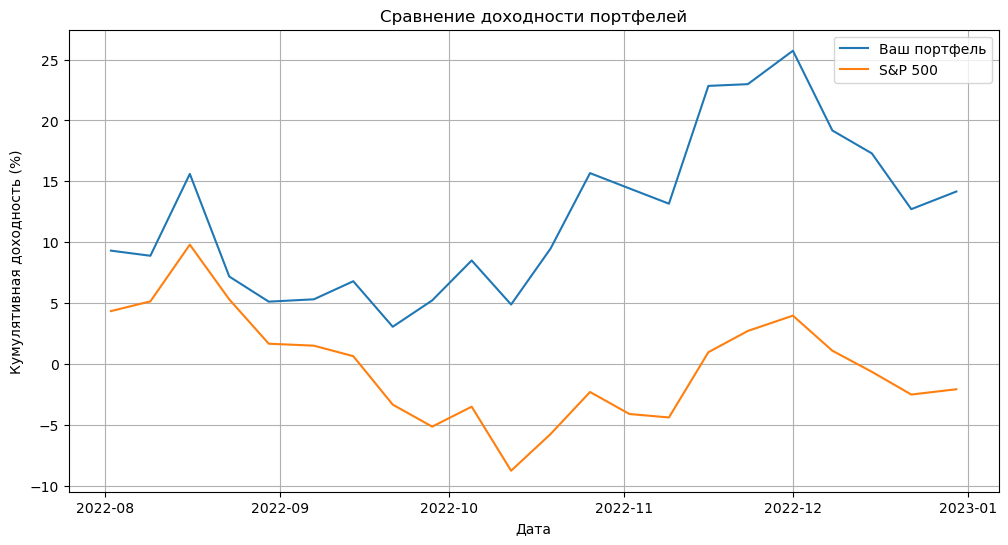

In [22]:
# Создание DataFrame для сравнения
comparison_df = pd.DataFrame({
    'Date': dates,
    'Portfolio Return': portfolio_returns,
    'Index Return': index_returns
})

# Рассчитываем кумулятивную доходность
comparison_df['Portfolio Cumulative Return'] = (1 + comparison_df['Portfolio Return']).cumprod() - 1
comparison_df['Index Cumulative Return'] = (1 + comparison_df['Index Return']).cumprod() - 1

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Portfolio Cumulative Return'] * 100, label='Ваш портфель')
plt.plot(comparison_df['Date'], comparison_df['Index Cumulative Return'] * 100, label='S&P 500')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная доходность (%)')
plt.title('Сравнение доходности портфелей')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Сохранение истории портфеля в CSV
portfolio_records = []

for entry in portfolio_history:
    date = entry['Date']
    portfolio_return = entry['Return']
    sp500_return = entry['SP500 Return']
    for ticker, info in entry['Portfolio'].items():
        portfolio_records.append({
            'Date': date,
            'Ticker': ticker,
            'Investment Fraction': info['Investment Fraction'],
            'Portfolio Return': portfolio_return,
            'SP500 Return': sp500_return
        })

portfolio_df = pd.DataFrame(portfolio_records)
portfolio_df.to_csv('data/portfolio_history.csv', index=False)
print("Информация о портфеле сохранена в 'portfolio_history.csv'")

Информация о портфеле сохранена в 'portfolio_history.csv'


In [26]:
# Расчет среднегодовой доходности (CAGR)
total_days = (comparison_df['Date'].iloc[-1] - comparison_df['Date'].iloc[0]).days
years = total_days / 365.25

portfolio_cagr = ((comparison_df['Portfolio Cumulative Return'].iloc[-1] + 1) ** (1 / years)) - 1
index_cagr = ((comparison_df['Index Cumulative Return'].iloc[-1] + 1) ** (1 / years)) - 1

print(f"\nСреднегодовая доходность вашего портфеля: {portfolio_cagr * 100:.2f}%")
print(f"Среднегодовая доходность индекса S&P 500: {index_cagr * 100:.2f}%")

# Расчет коэффициента Шарпа
portfolio_std = comparison_df['Portfolio Return'].std()
index_std = comparison_df['Index Return'].std()

portfolio_sharpe = (comparison_df['Portfolio Return'].mean()) / portfolio_std * np.sqrt(52)  # 52 недели в году
index_sharpe = (comparison_df['Index Return'].mean()) / index_std * np.sqrt(52)

print(f"Коэффициент Шарпа вашего портфеля: {portfolio_sharpe:.2f}")
print(f"Коэффициент Шарпа индекса S&P 500: {index_sharpe:.2f}")

# Расчет максимальной просадки
def max_drawdown(return_series):
    cumulative = (1 + return_series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    return max_dd

portfolio_max_dd = max_drawdown(comparison_df['Portfolio Return'])
index_max_dd = max_drawdown(comparison_df['Index Return'])

print(f"Максимальная просадка вашего портфеля: {portfolio_max_dd * 100:.2f}%")
print(f"Максимальная просадка индекса S&P 500: {index_max_dd * 100:.2f}%")


Среднегодовая доходность вашего портфеля: 38.06%
Среднегодовая доходность индекса S&P 500: -4.99%
Коэффициент Шарпа вашего портфеля: 1.16
Коэффициент Шарпа индекса S&P 500: -0.12
Максимальная просадка вашего портфеля: -10.86%
Максимальная просадка индекса S&P 500: -16.91%
